# Loading the data

In [1]:
import keras
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('../../dataset/train.csv')

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
print ("The Columns:", df.columns.values)

The Columns: ['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate']


In [5]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
for col in ['toxic','severe_toxic','obscene','threat','insult','identity_hate']:
  print (col, "\tunique values:", df[col].unique() )


toxic 	unique values: [0 1]
severe_toxic 	unique values: [0 1]
obscene 	unique values: [0 1]
threat 	unique values: [0 1]
insult 	unique values: [0 1]
identity_hate 	unique values: [0 1]


# Dealing with imbalance data

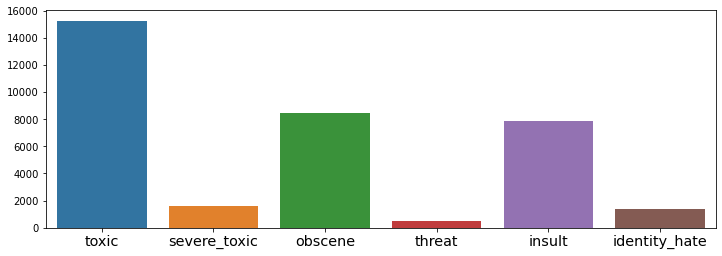

In [7]:
target_columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

class_sum = [df[col].sum() for col in target_columns]

fig, ax = plt.subplots(1,1, figsize=(12,4))
sns.barplot(x=target_columns, y=class_sum, ax=ax)
ax.set_xticklabels(target_columns, fontsize='x-large');

In [8]:
for col in target_columns:
    print (col, df[col].sum())

toxic 15294
severe_toxic 1595
obscene 8449
threat 478
insult 7877
identity_hate 1405


In [9]:
def imbalance_metric(df, target_columns):
    label_counts = np.array([df[col].sum() for col in target_columns])
    IRpL = np.max(label_counts)/label_counts
    meanIR = np.sum(IRpL)/len(IRpL)
    return meanIR

print('mean imbalance ratio (smaller is better):', imbalance_metric(df, target_columns))

mean imbalance ratio (smaller is better): 9.536949511086547


In [10]:
# Undersample the data to minimize imbalance ratio

sample_per_label = 500 # we can play with this number, larger number means more imbalance

counts = {'toxic':0, 'severe_toxic':0, 'obscene':0, 'threat':0, 'insult':0, 'identity_hate':0}

new_df = pd.DataFrame()

for label in target_columns:
    sample_to_add = np.max([sample_per_label - counts[label], 0])
    
    if sample_to_add <= 0: continue
    
    s = df[df[label] == 1].sample(n=np.min([sample_to_add, df[label].sum()]))
    df.drop(s.index, inplace=True)
    
    new_df = new_df.append(s, ignore_index=True)
    
    # count labels
    for col in target_columns:
        counts[col] += s[col].sum()


In [11]:
counts

{'toxic': 1616,
 'severe_toxic': 629,
 'obscene': 1161,
 'threat': 478,
 'insult': 1150,
 'identity_hate': 500}

In [12]:
for col in target_columns:
    print (col, new_df[col].sum())

toxic 1616
severe_toxic 629
obscene 1161
threat 478
insult 1150
identity_hate 500


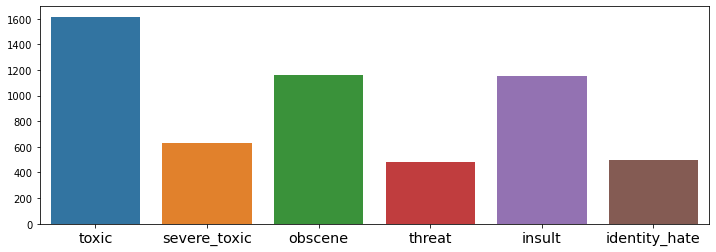

In [13]:
target_columns = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

class_sum = [new_df[col].sum() for col in target_columns]

fig, ax = plt.subplots(1,1, figsize=(12,4))
sns.barplot(x=target_columns, y=class_sum, ax=ax)
ax.set_xticklabels(target_columns, fontsize='x-large');

In [14]:
print('mean imbalance ratio (smaller is better):', imbalance_metric(new_df, target_columns))

mean imbalance ratio (smaller is better): 2.16317190891748


In [15]:
len(new_df)

1662

In [16]:
del df
df = new_df
del new_df

# Preprocessing: tokens to vectors

In [17]:
tokenizer = TweetTokenizer()
df['tokens'] = df['comment_text'].str.lower().apply(tokenizer.tokenize)

In [18]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,tokens
0,f578257c258c9fc5,Stop the mad gorilla deleter! \n\n Gorilla sco...,1,0,0,0,0,0,"[stop, the, mad, gorilla, deleter, !, gorilla,..."
1,4f2df0a1ec5380c1,Really good contributor? Bullshit. The cabal d...,1,0,1,0,0,0,"[really, good, contributor, ?, bullshit, ., th..."
2,7b3d18857df782cf,FUCK YOU,1,1,1,0,1,0,"[fuck, you]"
3,9b4b3f81be32582a,"Sore loser, Nawlinwiki! I still got over 150 ...",1,0,0,0,0,0,"[sore, loser, ,, nawlinwiki, !, i, still, got,..."
4,c33d7b2d87e78295,Queen Mary \n\nMrs Windsor's granny.She was a ...,1,0,1,0,1,0,"[queen, mary, mrs, windsor's, granny.she, was,..."


In [19]:
cachedStopWords = stopwords.words("english")
def remove_stopwords(tokens):
    return [token for token in tokens if token not in cachedStopWords]

df['tokens_nostop'] = df['tokens'].apply(remove_stopwords)

In [20]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,tokens,tokens_nostop
0,f578257c258c9fc5,Stop the mad gorilla deleter! \n\n Gorilla sco...,1,0,0,0,0,0,"[stop, the, mad, gorilla, deleter, !, gorilla,...","[stop, mad, gorilla, deleter, !, gorilla, scol..."
1,4f2df0a1ec5380c1,Really good contributor? Bullshit. The cabal d...,1,0,1,0,0,0,"[really, good, contributor, ?, bullshit, ., th...","[really, good, contributor, ?, bullshit, ., ca..."
2,7b3d18857df782cf,FUCK YOU,1,1,1,0,1,0,"[fuck, you]",[fuck]
3,9b4b3f81be32582a,"Sore loser, Nawlinwiki! I still got over 150 ...",1,0,0,0,0,0,"[sore, loser, ,, nawlinwiki, !, i, still, got,...","[sore, loser, ,, nawlinwiki, !, still, got, 15..."
4,c33d7b2d87e78295,Queen Mary \n\nMrs Windsor's granny.She was a ...,1,0,1,0,1,0,"[queen, mary, mrs, windsor's, granny.she, was,...","[queen, mary, mrs, windsor's, granny.she, bitc..."


In [21]:
def join_tokens(tokens):
    return ' '.join(tokens)

df['join_tokens'] = df['tokens_nostop'].apply(join_tokens)

In [22]:
df.drop(['id','comment_text'], axis=1, inplace=True)
df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,tokens,tokens_nostop,join_tokens
0,1,0,0,0,0,0,"[stop, the, mad, gorilla, deleter, !, gorilla,...","[stop, mad, gorilla, deleter, !, gorilla, scol...",stop mad gorilla deleter ! gorilla scolded ins...
1,1,0,1,0,0,0,"[really, good, contributor, ?, bullshit, ., th...","[really, good, contributor, ?, bullshit, ., ca...",really good contributor ? bullshit . cabal dis...
2,1,1,1,0,1,0,"[fuck, you]",[fuck],fuck
3,1,0,0,0,0,0,"[sore, loser, ,, nawlinwiki, !, i, still, got,...","[sore, loser, ,, nawlinwiki, !, still, got, 15...","sore loser , nawlinwiki ! still got 150 nice r..."
4,1,0,1,0,1,0,"[queen, mary, mrs, windsor's, granny.she, was,...","[queen, mary, mrs, windsor's, granny.she, bitc...",queen mary mrs windsor's granny.she bitch .


Stratification

## Bag of Words

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(df.join_tokens.to_list()).toarray()

In [24]:
np.shape(bow_matrix)

(1662, 7591)

Too many basis words. Use PCA to cut them.

In [25]:
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
#from sklearn.pipeline import Pipeline

#pca_pipe = Pipeline([('scale', StandardScaler()), ('pca', PCA())])

#pca_pipe.fit(bow_matrix)

# n-grams

In [26]:
bigrams = CountVectorizer(ngram_range=(2,2))
bigrams_matrix = bigrams.fit_transform(df.join_tokens.to_list())

In [27]:
names = bigrams.get_feature_names()

In [28]:
import random
random.choices(names, k=10)

['send barnstars',
 'eons asshole',
 'niggers around',
 'theyre noteable',
 'guys try',
 'stupid bastard',
 'life know',
 'king kamehameha',
 'well say',
 'world love']

In [29]:
np.shape(bigrams_matrix)

(1662, 24334)

# TF-IDF

In [30]:
vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(df.join_tokens.to_list()).toarray()

In [31]:
np.shape(tfidf_matrix)

(1662, 7591)

## Splitting into train and test with stratify

now just for tfidf

In [32]:
X_train, y_train, X_test, y_test = iterative_train_test_split(tfidf_matrix, df[target_columns].to_numpy(), test_size = 0.2)

In [33]:
a = dict(Counter(combination for row in get_combination_wise_output_matrix(y_train, order=1) for combination in row))

{k: v / total for total in (sum(a.values()),) for k, v in a.items()}

{(0,): 0.2837370242214533,
 (2,): 0.21314878892733563,
 (4,): 0.20945790080738177,
 (5,): 0.09065743944636678,
 (1,): 0.11510957324106114,
 (3,): 0.08788927335640138}

In [34]:
a = dict(Counter(combination for row in get_combination_wise_output_matrix(y_test, order=1) for combination in row))

{k: v / total for total in (sum(a.values()),) for k, v in a.items()}

{(0,): 0.3219349457881568,
 (1,): 0.10842368640533778,
 (2,): 0.19766472060050042,
 (4,): 0.2018348623853211,
 (5,): 0.08924103419516263,
 (3,): 0.08090075062552127}

# Modeling

In [35]:
clf = OneVsRestClassifier(LogisticRegression())

In [36]:
print('Accuracy per label')
for i in range(len(target_columns)):
    clf.fit(X_train, y_train[:,i])
    pred = clf.predict(X_test)
    print(target_columns[i], accuracy_score(y_test[:,i], pred))

Accuracy per label
toxic 0.9578163771712159
severe_toxic 0.7642679900744417
obscene 0.607940446650124
threat 0.8387096774193549
insult 0.6228287841191067
identity_hate 0.7791563275434243


In [37]:
from sklearn.multioutput import MultiOutputClassifier

In [38]:
mlc = MultiOutputClassifier(LogisticRegression())
mlc.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression())

In [39]:
pred = mlc.predict(X_test)

In [40]:
mcm = multilabel_confusion_matrix(y_test, pred)

Accuracy per label
toxic 0.9578163771712159
severe_toxic 0.7642679900744417
obscene 0.607940446650124
threat 0.8387096774193549
insult 0.6228287841191067
identity_hate 0.7791563275434243


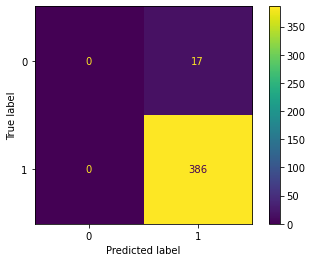

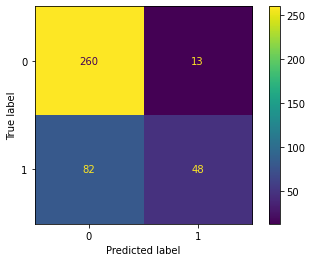

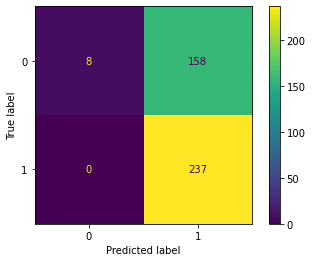

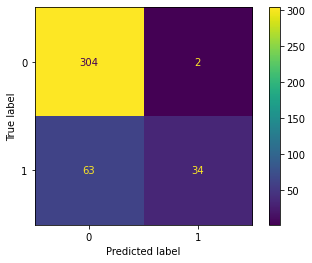

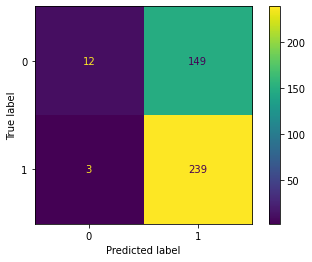

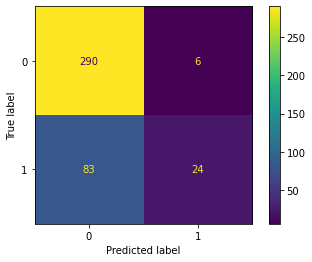

In [41]:
print('Accuracy per label')
for i in range(len(target_columns)):
    print(target_columns[i], (mcm[i,0,0]+mcm[i,1,1])/np.sum(mcm[i]))
    disp = ConfusionMatrixDisplay(mcm[i])
    disp.plot()

In [42]:
# https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics
# Accuracy for multilabel classifier
def Accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]

In [43]:
Accuracy(y_test, pred)

0.643424317617866

In [44]:
def exact_match_ratio(y_true, y_pred):
    return np.all(y_pred == y_true, axis=1).mean()

exact_match_ratio(y_test, pred)

0.24069478908188585

In [45]:
accuracy_score(y_test, pred) # is the exact match ratio

0.24069478908188585

## Neural Network

In [56]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.metrics import binary_accuracy

In [47]:
def build_network(n_features, n_output, n_layers=1, n_nodes=10, activ_func='relu', dropout_rate=0.):
    ''' Building neural network model '''
    model = Sequential()
    model.add(Dense(n_nodes, activation=activ_func, use_bias=True, input_shape=(n_features,)))
    for i in range(n_layers-1):
        model.add(Dense(n_nodes, activation=activ_func, use_bias=True))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate, input_shape=(n_nodes,)))
    model.add(Dense(n_output, activation='sigmoid'))
    return model

In [57]:
def fit_network(X, y, n_output, n_layers=1, n_nodes=10, activ_func='relu', dropout_rate=0., epochs=10):
    # Building neural network model
    n_features = np.shape(X)[1]
    model = build_network(n_features, n_output, n_layers, n_nodes, activ_func, dropout_rate)
    # Compiling model
    early_stopping_monitor = EarlyStopping(patience=5)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[binary_accuracy])
    # Fitting model
    history = model.fit(X, y,
                        validation_split=0.2, epochs=epochs,
                        shuffle=True, callbacks=[early_stopping_monitor])
    #model.save('neuralnetwork.h5')
    return model

In [61]:
model = fit_network(X_train, y_train, n_output=y_train.shape[1], epochs=50)

Epoch 1/50
32/32 [==============================] - 0s 5ms/step - loss: 0.6895 - binary_accuracy: 0.5986 - val_loss: 0.6742 - val_binary_accuracy: 0.7798
Epoch 2/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6679 - binary_accuracy: 0.7563 - val_loss: 0.6495 - val_binary_accuracy: 0.7632
Epoch 3/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6398 - binary_accuracy: 0.7472 - val_loss: 0.6220 - val_binary_accuracy: 0.7553
Epoch 4/50
32/32 [==============================] - 0s 2ms/step - loss: 0.6078 - binary_accuracy: 0.7323 - val_loss: 0.5951 - val_binary_accuracy: 0.7553
Epoch 5/50
32/32 [==============================] - 0s 3ms/step - loss: 0.5714 - binary_accuracy: 0.7385 - val_loss: 0.5718 - val_binary_accuracy: 0.7553
Epoch 6/50
32/32 [==============================] - 0s 3ms/step - loss: 0.5361 - binary_accuracy: 0.7369 - val_loss: 0.5569 - val_binary_accuracy: 0.7560
Epoch 7/50
32/32 [==============================] - 0s 3ms/step - loss: 0.51

In [62]:
y_pred = model.predict(X_test)

In [68]:
Accuracy(y_test, y_pred.round())

0.6249793217535153

In [69]:
exact_match_ratio(y_test, y_pred.round())

0.25806451612903225